# 睡眠時の脳波

In [1]:
import math
import plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## グラフのプロット

In [2]:
figsize = (20, 3)
rate = 20 # 秒間に受け取るデータ量
def plot_spec_ppg(file_name):
    pd.options.plotting.backend = "matplotlib"
    header = ["ts", "anb", "ir", "red"]
    df = pd.read_csv(file_name, names=header)
    df["ts"] = df["ts"] - df.iloc[0]["ts"]
    df = df.set_index("ts")
    df["spo2"] = df["red"] / df["ir"]
    df = df.loc[:,["spo2"]]
    fig = df.plot(title=file_name, figsize=figsize)

# 加速度センサーとジャイロセンサのデータをプロット
# ジャイロセンサは回転を検出できるセンサです。
# 加速度センサは動きを検出できますが、回転は検出できません。 
def plot_spec_xyz(file_name):
    pd.options.plotting.backend = "matplotlib"
    header = ["ts", "X", "Y", "Z"]
    df_xyz = pd.read_csv(file_name, names=header)
    df_xyz["ts"] = df_xyz["ts"] - df_xyz.iloc[0]["ts"]
    df_xyz = df_xyz.set_index("ts")
    df_xyz = df_xyz.rolling(600*rate).max()
    fig = df_xyz.plot(title=file_name, figsize=figsize)

# 睡眠状態をプロット
def plot_sleep_stage(waves_file_name, gyro_file_name):
    pd.options.plotting.backend = "matplotlib"
    stage = "wakeup"
    fillcolor_map = {"wakeup": "yellow", "nonrem": "blue", "rem": "green"}
    x0 = 0
    x1 = 0
    
    header = ["ts", "abs_delta", "abs_theta", "abs_alpha", "abs_beta", "abs_gamma", "rel_delta", "rel_theta", "rel_alpha", "rel_beta", "rel_gamma", "hsi"]
    df = pd.read_csv(waves_file_name, names=header)
    df["ts"] = df["ts"] - df.iloc[0]["ts"]
    df = df.set_index("ts")
    df["offset"] = df["rel_delta"] - df["rel_alpha"]
    df["offset"] = df["offset"].rolling(600*rate).mean()
    df = df.dropna()
    df_offset = df.loc[:,["offset"]]
    
    # グラフの作成
    fig = df_offset.plot(title='sleep stage', figsize=figsize)
    fig.axhline(y=0.25, linestyle=':', color='black')
    fig.axhline(y=0,linestyle=':', color='black')
    fig.axhline(y=-0.2,linestyle=':', color='black')

    # ジャイロセンサーデータの読み込み
    header = ["ts", "X", "Y", "Z"]
    df_xyz = pd.read_csv(gyro_file_name, names=header)
    df_xyz["ts"] = df_xyz["ts"] - df_xyz.iloc[0]["ts"]
    df_xyz = df_xyz.set_index("ts")
    df_xyz = df_xyz.rolling(600*rate).max()
    # X Y Zの平均値を求める
    df_xyz["avg"] = df_xyz.mean(axis=1)
    df_xyz = df_xyz.dropna()
    df_xyz = df_xyz.loc[:,["avg"]]

    for index,item in df_xyz.iterrows():
        # 10分間体の動きが無ければ入眠とする
        if item["avg"] < 20:
            if x0 != index:
                x1 = index
                fillcolor = fillcolor_map[stage]
                fig.axvspan(x0, x1, alpha=0.2, color=fillcolor)
            x0 = index
            stage = "rem"
            break

    for index,item in df_offset.iterrows():
        # ノンレム睡眠
        if item["offset"] > 0.23 and stage != "nonrem":
            if x0 != index:
                x1 = index
                fillcolor = fillcolor_map[stage]
                fig.axvspan(x0, x1, alpha=0.2, color=fillcolor)
            x0 = index
            stage = "nonrem"
        # レム睡眠
        if item["offset"] < 0 and stage == "nonrem":
            if x0 != index:
                x1 = index
                fillcolor = fillcolor_map[stage]
                fig.axvspan(x0, x1, alpha=0.2, color=fillcolor)
            x0 = index
            stage = "rem"
    
    stage = "rem"
    fillcolor = fillcolor_map[stage]
    fig.axvspan(x0, index, alpha=0.2, color=fillcolor)

In [3]:
rate = 20 # 秒間に受け取るデータ量
def predict_sleep_stage(waves_file_name):
    stage = "wakeup"
    try:
        header = ["ts", "abs_delta", "abs_theta", "abs_alpha", "abs_beta", "abs_gamma", "rel_delta", "rel_theta", "rel_alpha", "rel_beta", "rel_gamma", "hsi"]
        df = pd.read_csv(waves_file_name, names=header)
        df["ts"] = df["ts"] - df.iloc[0]["ts"]
        df = df.set_index("ts")

        df = df.head(-600*rate)

        df["offset"] = df["rel_delta"] - df["rel_alpha"]
        df["offset"] = df["offset"].rolling(600*rate).mean()
        df = df.dropna()
        df_offset = df.loc[:,["offset"]]
        offset = df_offset.iloc[-1]["offset"]
        if -0.2 < offset < 0.25:
            stage = "rem"
        if offset > 0.25:
            stage = "nonrem"
    except Exception as e:
        print(e)
    return stage

import requests
def play_sound(rpi_host, stage):
    url = f"http://{rpi_host}:8000/sleep/{stage}"
    requests.get(url)

In [4]:
csvdir = "/logs/sleep-2022-05-09"
csvdir = "/logs/sleep-2022-05-18"
#csvdir = "/logs/sleep-2022-05-23/"

## 睡眠ステージの分類
* アルファー波とデルタ波の差分の10分移動平均(基本指標)を閾値として睡眠ステージを分類してみる
* ノンレム睡眠からレム睡眠に切り替わるタイミングに寝返りを打つことが多いことから、ジャイロセンサーの閾値と基本指標からステージ変更を検知する
* 入眠のタイミングはジャイロセンサーの10分移動平均を閾値と基本指標から判定する
* 覚醒時も同様に基本指標とジャイロセンサーの閾値から判定する

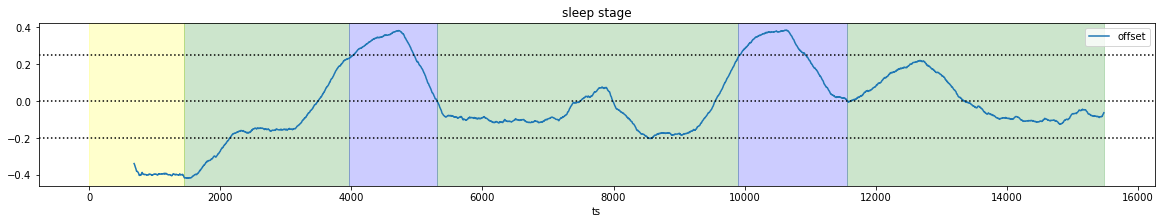

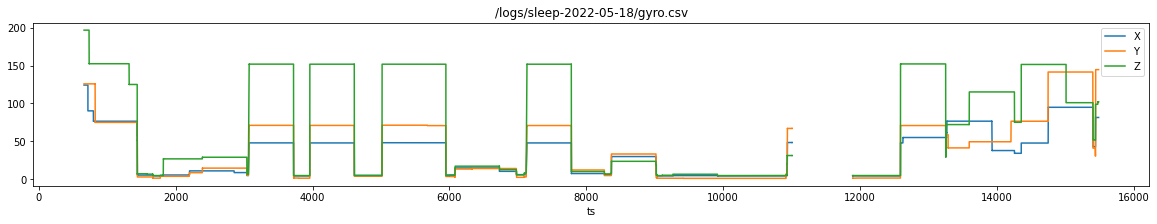

In [5]:
plot_sleep_stage(f"{csvdir}/waves.csv", f"{csvdir}/gyro.csv")
plot_spec_xyz(f"{csvdir}/gyro.csv")

## 脳波の分布

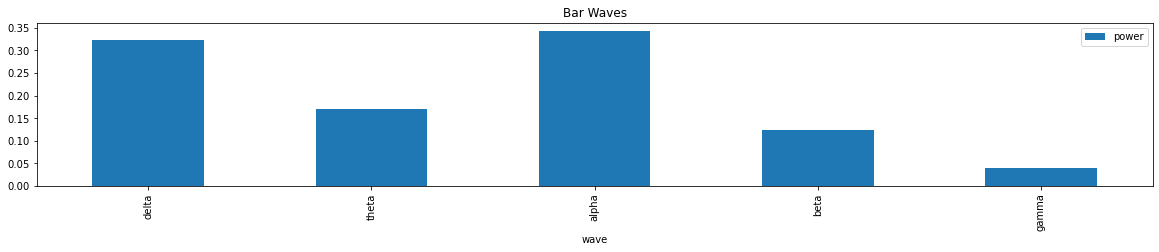

In [6]:
csvfile=f"{csvdir}/waves.csv"
header = ["ts", "abs_delta", "abs_theta", "abs_alpha", "abs_beta", "abs_gamma", "rel_delta", "rel_theta", "rel_alpha", "rel_beta", "rel_gamma", "hsi"]
df = pd.read_csv(csvfile, names=header)
df = df.set_index("ts")
# 非正規化データ
#df = df.loc[:,["abs_delta", "abs_theta", "abs_alpha", "abs_beta", "abs_gamma"]]
# 正規化データ
df = df.loc[:,["rel_delta", "rel_theta", "rel_alpha", "rel_beta", "rel_gamma"]]
# 棒グラフを表示
df.columns = ["delta", "theta", "alpha", "beta", "gamma"]
df_stack = df.mean()
df_stack = df_stack.reset_index()
df_stack.columns = ["wave", "power"]
fig = df_stack.plot.bar(x="wave", y="power", title='Bar Waves', figsize=(20, 3))

## 脳波の種類
* δ波（デルタ波）：深い睡眠の状態時に出る脳波
* θ波（シータ波）：浅い睡眠でまどろみの状態時に出る脳波
* α波（アルファ波）：リラックスした状態時に出る脳波
* β波（ベータ波）：通常の覚醒している状態時に出る脳波
* γ波（ガンマ波）：イライラしている状態時に出る脳波